### 💾💻📊 Data Science - MMI Portfolio No. 3
# 💥 Sentiment Analysis (NLP + Machine Learning) 💥



An extremely common dataset for benchmarking, method development, and tutorials is **MNIST** consisting of handwritten digits. In reference to this dataset several variants appeared such as sign-MNIST (photos of hand gestures for sign language), audioMNIST (audiofiles of spoken digits) and **fashionMNIST** made of low resolution photos of 10 types of clothes. We will here use this tp explore different possibilities for using dimensionality reduction techniques.

Please complete the following exercises:
## 1. Data Exploration and Cleaning
- Select equal number of reviews for all possible ratings (1 to 5).
- Use suitable Python libraries to detect the language for every restaurant review, for instance `langdetect`.
- Show a distribution of detected languages.
- Continue to work only with English entries.

Hint: This could take a little while, so better use `tqdm` or similar to show the progress.

## 2. TF-IDF + Logistic Regression vs Linear Regression
- Use the `TfidfVectorizer` to create vectors of all remaining reviews.
- Train a Logistic Regression model on the 5 rating classes
- Train a Linear Regression model on the rating (1 to 5).
- Compare both models, which works better?
- Also compare single tokens vs. 1 + 2-grams (`ngrams = (1,2)`), which works better.
- Show the 10 most relevant words (or ngrams) for predicting high or low ratings.

## 3. Language Model --> word vectors + Logistic Regression vs. Random Forest
- Use Spacy and a larger English language model (`spacy.load("en_core_web_lg")`) to create vectors for each review. This might take a while so use a progress bar.
- Train a Logistic Regression model as well as a RandomForestClassifier on the review embeddings to predict the 5 rating classes.
- Evaluate the performance of both models, and also compare to the TF-IDF case before.



## General instructions
- The final notebook should be executable in the correct order (this means it should work if you do `Kernel` --> `Restart kernel and run all cells...`)
- Just providing code and plots is not enough, you should document and comment where necessary. Not so much on small code-related things (you may still do this if you want though, but this is not required), but mostly to explain what you do, why you do it, what you observe.

More specifically:
- Please briefly comment on the changes you make to the data, in particular if you apply complex operations or if your changes depend on a certain choice you have to make.
- Please add descriptions and/or interpretations to the results you generate (for instance tables, plots). This doesn't have to be a lot of text. For simple, easy-to-understand results, a brief sentence can be enough. For more complex results, you might want to add a bit more explanation.

---
Please add your Name here
## Name: Kevin Zielke

---

## Imports and helper function
Use this part to import the main libraries used in this notebook.  
Also add more complex helper functions to this part (if you use any).

In [370]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy

from tqdm.notebook import tqdm

# add imports if anything is missing
# for instance. feel free to use other plotting libraries (e.g. seaborn, plotly...)

## Data download and import
The following analysis should be done with data from TripAdvisor, namely restraurant reviews from **Barcelona**. You can find the respective data (`Barcelona_reviews.csv`) on the [TripAdvisor data](https://zenodo.org/records/6583422).


In [371]:
path = os.path.join("..", "..", "Datasets", "Tripadvisor")
filename = os.path.join(path, "Barcelona_reviews.csv")
data = pd.read_csv(filename)
data = data.drop(["Unnamed: 0"], axis=1)
data.head()

C:\Users\kevin\AppData\Local\Temp\ipykernel_19056\1716722039.py:3: DtypeWarning: Columns (0,1,3) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(filename)


,parse_count,restaurant_name,rating_review,sample,review_id,title_review,review_preview,review_full,date,city,url_restaurant,author_id
0,1,Chalito_Rambla,1,Negative,review_774086112,Terrible food Terrible service,"Ok, this place is terrible! Came here bc we’ve...","Ok, this place is terrible! Came here bc we’ve...","October 12, 2020",Barcelona_Catalonia,https://www.tripadvisor.com/Restaurant_Review-...,UID_0
1,2,Chalito_Rambla,5,Positive,review_739142140,The best milanesa in central Barcelona,This place was a great surprise. The food is d...,This place was a great surprise. The food is d...,"January 14, 2020",Barcelona_Catalonia,https://www.tripadvisor.com/Restaurant_Review-...,UID_1
2,3,Chalito_Rambla,5,Positive,review_749758638,Family bonding,The food is excellent.....the ambiance is very...,The food is excellent.....the ambiance is very...,"March 7, 2020",Barcelona_Catalonia,https://www.tripadvisor.com/Restaurant_Review-...,UID_2
3,4,Chalito_Rambla,5,Positive,review_749732001,Best food,"The food is execellent ,affortable price for p...","The food is execellent ,affortable price for p...","March 7, 2020",Barcelona_Catalonia,https://www.tripadvisor.com/Restaurant_Review-...,UID_3
4,5,Chalito_Rambla,5,Positive,review_749691057,Amazing Food and Fantastic Service,"Mr Suarez,The food at your restaurant was abso...","Mr Suarez,The food at your restaurant was abso...","March 7, 2020",Barcelona_Catalonia,https://www.tripadvisor.com/Restaurant_Review-...,UID_4


In [372]:
# Some cleaning
mask = data.rating_review == "Barcelona_Catalonia"
data = data[~mask]
data.rating_review = data.rating_review.astype(int)

## 1. Data Exploration and Cleaning

Hint: This could take a little while, so better use `tqdm` or similar to show the progress.

In [373]:
import tqdm as tqdm

In [374]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 416355 entries, 0 to 416355
Data columns (total 12 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   parse_count      416355 non-null  object
 1   restaurant_name  416355 non-null  object
 2   rating_review    416355 non-null  int32 
 3   sample           416355 non-null  object
 4   review_id        416355 non-null  object
 5   title_review     416355 non-null  object
 6   review_preview   416355 non-null  object
 7   review_full      416354 non-null  object
 8   date             416354 non-null  object
 9   city             416354 non-null  object
 10  url_restaurant   416354 non-null  object
 11  author_id        416354 non-null  object
dtypes: int32(1), object(11)
memory usage: 39.7+ MB


There is a single null value in the data. I will get rid of it, since a single missing entry wont affect the analysis.

In [375]:
data = data.dropna()

Exept for _rating_reviews_, all columns are strings. Some columns can be converted to proper data types that can be easier processed. _date_ for example can easily be converted to datime.

In [376]:
data.date = pd.to_datetime(data.date)

Every entry of _author_id_ contains "UID_" prefix. This can be removed and the column can be converted to integer.

In [377]:
data.author_id = data.author_id.str.removeprefix("UID_")
data.author_id = data.author_id.astype(int)

In [378]:
data.tail()

,parse_count,restaurant_name,rating_review,sample,review_id,title_review,review_preview,review_full,date,city,url_restaurant,author_id
416351,426639,Bodega_Biarritz,5,Positive,review_656474442,Awesome spot!,What a cute little hole in wall! The decorum w...,What a cute little hole in wall! The decorum w...,2019-03-04,Barcelona_Catalonia,https://www.tripadvisor.com/Restaurant_Review-...,232019
416352,426640,Bodega_Biarritz,5,Positive,review_656066564,Great tapas and great service,We really enjoyed the tapas here. Each of the...,We really enjoyed the tapas here. Each of the ...,2019-03-03,Barcelona_Catalonia,https://www.tripadvisor.com/Restaurant_Review-...,57970
416353,426641,Bodega_Biarritz,5,Positive,review_631216398,Fabulous Tapas,Tried to get a table at Bodega Biarritz 1820 b...,Tried to get a table at Bodega Biarritz 1820 b...,2018-11-06,Barcelona_Catalonia,https://www.tripadvisor.com/Restaurant_Review-...,36360
416354,426642,Bodega_Biarritz,5,Positive,review_630522900,Fantastic!,It was our first time eating tapas and it was ...,It was our first time eating tapas and it was ...,2018-11-03,Barcelona_Catalonia,https://www.tripadvisor.com/Restaurant_Review-...,18363
416355,426643,Bodega_Biarritz,5,Positive,review_630287967,Great experience,We went early (6.00pm) to avoid queuing as we ...,We went early (6.00pm) to avoid queuing as we ...,2018-11-02,Barcelona_Catalonia,https://www.tripadvisor.com/Restaurant_Review-...,40467


In [379]:
data.review_id.value_counts()

review_id
review_774086112    1
review_495623401    1
review_500779404    1
review_500845386    1
review_501058790    1
                   ..
review_582017693    1
review_584876128    1
review_475586397    1
review_476139753    1
review_630287967    1
Name: count, Length: 416354, dtype: int64

By looking at data.head() and data.tail() it looks like the column _parse_count_ is just a messed up ID column. There is also _review_id_, which is another ID column. I will drop them both, because it clutters the output and I will just use the dataframe indexing.

In [380]:
data.drop(["parse_count", "review_id"], axis=1, inplace=True)

The _sample_ column only contains the entries positive and negative. We can turn this into a boolean column, where positive is TRUE and negative is FALSE.

In [381]:
data["sample"].value_counts()

sample
Positive    338778
Negative     77576
Name: count, dtype: int64

In [382]:
positive_mask = data["sample"] == "Positive"
negative_mask = data["sample"] == "Negative"

data.loc[positive_mask, "sample"] = 1
data.loc[negative_mask, "sample"] = 0

data["sample"] = data["sample"].astype(bool)

Finally I like to code data.sample more than data["sample"]. I will rename the _sample_ column to _bias_ so that python does not mistake this writing for the dataframe method sample(). Also i like short column names in general, so I will rename some of them. 

In [383]:
data = data.rename(columns={"sample": "bias",
                            "restaurant_name": "restaurant",
                            "rating_review": "rating",
                            "title_review": "title",
                            "review_preview": "preview",
                            "review_full": "full" })

In [384]:
data.head()

,restaurant,rating,bias,title,preview,full,date,city,url_restaurant,author_id
0,Chalito_Rambla,1,False,Terrible food Terrible service,"Ok, this place is terrible! Came here bc we’ve...","Ok, this place is terrible! Came here bc we’ve...",2020-10-12,Barcelona_Catalonia,https://www.tripadvisor.com/Restaurant_Review-...,0
1,Chalito_Rambla,5,True,The best milanesa in central Barcelona,This place was a great surprise. The food is d...,This place was a great surprise. The food is d...,2020-01-14,Barcelona_Catalonia,https://www.tripadvisor.com/Restaurant_Review-...,1
2,Chalito_Rambla,5,True,Family bonding,The food is excellent.....the ambiance is very...,The food is excellent.....the ambiance is very...,2020-03-07,Barcelona_Catalonia,https://www.tripadvisor.com/Restaurant_Review-...,2
3,Chalito_Rambla,5,True,Best food,"The food is execellent ,affortable price for p...","The food is execellent ,affortable price for p...",2020-03-07,Barcelona_Catalonia,https://www.tripadvisor.com/Restaurant_Review-...,3
4,Chalito_Rambla,5,True,Amazing Food and Fantastic Service,"Mr Suarez,The food at your restaurant was abso...","Mr Suarez,The food at your restaurant was abso...",2020-03-07,Barcelona_Catalonia,https://www.tripadvisor.com/Restaurant_Review-...,4


Now the full dataframe fits my screen and every column has the best possible dtype.

In [385]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 416354 entries, 0 to 416355
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   restaurant      416354 non-null  object        
 1   rating          416354 non-null  int32         
 2   bias            416354 non-null  bool          
 3   title           416354 non-null  object        
 4   preview         416354 non-null  object        
 5   full            416354 non-null  object        
 6   date            416354 non-null  datetime64[ns]
 7   city            416354 non-null  object        
 8   url_restaurant  416354 non-null  object        
 9   author_id       416354 non-null  int32         
dtypes: bool(1), datetime64[ns](1), int32(2), object(6)
memory usage: 29.0+ MB


### 1.1 - Select equal number of reviews for all possible ratings (1 to 5).

2 is the least frequently given rating with 18178 entries. I will select 18178 random reviews for each rating. 

In [386]:
data.rating.value_counts()

rating
5    241976
4     96802
3     33148
1     26250
2     18178
Name: count, dtype: int64

In [387]:
samples = data.rating.value_counts().min()
data = data.groupby('rating').apply(lambda x: x.sample(n=samples))
data.rating.value_counts()

C:\Users\kevin\AppData\Local\Temp\ipykernel_19056\3631636527.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data = data.groupby('rating').apply(lambda x: x.sample(n=samples))


rating
1    18178
2    18178
3    18178
4    18178
5    18178
Name: count, dtype: int64

### 1.2 - Use suitable Python libraries to detect the language for every restaurant review, for instance `langdetect`.

I will create a new column _language_ and fill it with the detected language of the review. I will use the _preview_ of the review to detect the language, because it is processed faster than the whole review and has a sufficient amount of words to detect the language. I will also enable tqdm for the pandas.apply() function (and use progress_apply() instead), so that I can see the progress.

In [388]:
from langdetect import detect
from tqdm.auto import tqdm

tqdm.pandas()

In [389]:
filepath = os.path.join(path, "Barcelona_reviews_cleaned.csv")

try:
    data = pd.read_csv(filepath)
    print(f"Loaded detected languages from {filepath}")
except:
    print(f"Found no data at {filepath}. Detecting Languages:")

    data["language"] = data.preview.progress_apply(detect)
    data.to_csv(filepath, index=False)

data.head()

Found no data at ..\..\Datasets\Tripadvisor\Barcelona_reviews_cleaned.csv. Detecting Languages:


  0%|          | 0/90890 [00:00<?, ?it/s]

restaurant  rating   bias  \
rating                                                        
1      65483             Nineteen_Restaurant       1  False   
       384942                    El_Pi_Antic       1  False   
       332467  Restaurant_El_Beso_y_La_Lluna       1  False   
       259915                   Casa_Guinart       1  False   
       295951                          Bravo       1  False   

                                               title  \
rating                                                 
1      65483   4.50€ For a glass of sparkling water    
       384942   Avoid - poor quality and overpriced    
       332467                     One of the worst.    
       259915                      not so good tapas   
       295951                      Overpriced trap!!   

                                                         preview  \
rating                                                             
1      65483   Being from Barcelona, stop a minute to wait fo...   
       384942  Stumbled upon this place after a long days wor...   
       332467  Sometimes a restaurant experience is so bad yo...   
       259915  I am sorry to say but hit restaurant was very ...   
       295951  Was at Bravo during Mobile World Congress, I h...   

                                                            full       date  \
rating                                                                        
1      65483   Being from Barcelona, stop a minute to wait fo... 2016-07-24   
       384942  Stumbled upon this place after a long days wor... 2015-06-09   
       332467  Sometimes a restaurant experience is so bad yo... 2017-07-23   
       259915  I am sorry to say but hit restaurant was very ... 2019-05-28   
       295951  Was at Bravo during Mobile World Congress, I h... 2016-03-02   

                              city  \
rating                               
1      65483   Barcelona_Catalonia   
       384942  Barcelona_Catalonia   
       332467  Barcelona_Catalonia   
       259915  Barcelona_Catalonia   
       295951  Barcelona_Catalonia   

                                                  url_restaurant  author_id  \
rating                                                                        
1      65483   https://www.tripadvisor.com/Restaurant_Review-...      54770   
       384942  https://www.tripadvisor.com/Restaurant_Review-...     217874   
       332467  https://www.tripadvisor.com/Restaurant_Review-...     197546   
       259915  https://www.tripadvisor.com/Restaurant_Review-...     166297   
       295951  https://www.tripadvisor.com/Restaurant_Review-...     182238   

              language  
rating                  
1      65483        en  
       384942       en  
       332467       en  
       259915       en  
       295951       en

### 1.3 - Show a distribution of detected languages.

Pie plots are well suited to show the distribution of categorical data.

<Axes: ylabel='count'>

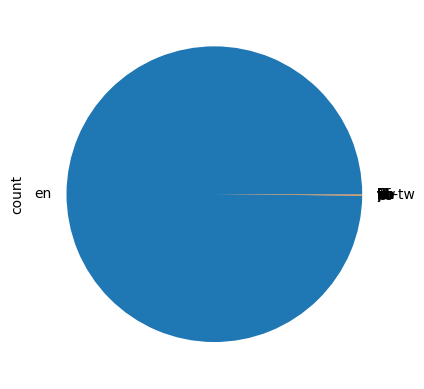

In [390]:
data.language.value_counts().plot(kind="pie")

### 1.4 - Continue to work only with English entries.

In [391]:
english_mask = data.language == "en"
data_cleaned = data[english_mask]

Our ratings were perfectly balanced because we selected the same amount of reviews for each rating in 1.1. After filtering out non-english reviews, the ratings are not perfectly balanced anymore, but as we can see in the pie plots, there were very few non-english reviews and the ratings are still very balanced.

<Axes: ylabel='count'>

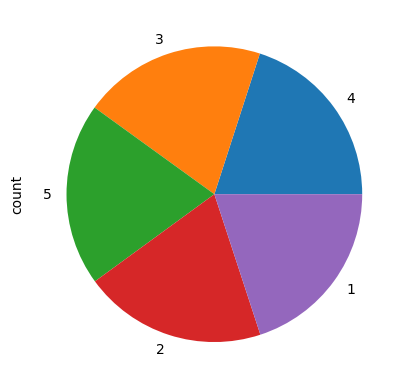

In [394]:
data_cleaned.rating.value_counts().plot(kind="pie")

## 2. TF-IDF + Logistic Regression vs Linear Regression

### 2.1 - Use the `TfidfVectorizer` to create vectors of all remaining reviews.

In [395]:
# Use the `TfidfVectorizer` to create vectors of all remaining reviews
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(data_cleaned.full)

### 2.2 - Train a Logistic Regression model on the 5 rating classes

In [397]:
# Train a Logistic Regression model on the 5 rating classes
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

X = vectors
y = data_cleaned.rating

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

logistic_regression = LogisticRegression(max_iter=1000)
logistic_regression.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

### 2.3 - Train a Linear Regression model on the rating (1 to 5).

In [398]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

linear_regression = LinearRegression()
linear_regression.fit(X_train, y_train)

LinearRegression()

### 2.4 - Compare both models, which works better?

In [400]:
logistic_pred = logistic_regression.predict(X_test)
linear_pred = linear_regression.predict(X_test)

print("Logistic Regression:")
print(classification_report(y_test, logistic_pred))
print("Linear Regression:")
print(classification_report(y_test, linear_pred))

Logistic Regression:
              precision    recall  f1-score   support

           1       0.68      0.73      0.71      3579
           2       0.52      0.48      0.50      3713
           3       0.56      0.53      0.55      3740
           4       0.55      0.55      0.55      3608
           5       0.69      0.73      0.71      3511

    accuracy                           0.60     18151
   macro avg       0.60      0.61      0.60     18151
weighted avg       0.60      0.60      0.60     18151

Linear Regression:


ValueError: Classification metrics can't handle a mix of multiclass and continuous targets

### 2.5 - Also compare single tokens vs. 1 + 2-grams (`ngrams = (1,2)`), which works better.

### 2.6 - Show the 10 most relevant words (or ngrams) for predicting high or low ratings.


## 3. Language Model --> word vectors + Logistic Regression vs. Random Forest

### 3.1 - Use Spacy and a larger English language model (`spacy.load("en_core_web_lg")`) to create vectors for each review. This might take a while so use a progress bar.

### 3.2 - Train a Logistic Regression model as well as a RandomForestClassifier on the review embeddings to predict the 5 rating classes.

### 3.3 - Evaluate the performance of both models, and also compare to the TF-IDF case before.